<a href="https://www.kaggle.com/code/aaronlee97/apple-quality-w-voting-classifier-pytorch?scriptVersionId=170721009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out Python Warnings
import warnings
warnings.filterwarnings('ignore')

# Configure CUBLAS workspace to 16:8 for more determinism (Reproducibility)
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'


In [8]:
cwd = os.getcwd()
KAGGLE = "kaggle" in cwd

if not KAGGLE :
    input_path = os.path.join(cwd)
    csv_path = os.path.join(input_path, "apple_quality.csv")
    
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if filename == "apple_quality.csv":
                path_train = os.path.join(dirname, filename)

# 0. Overview

This dataset comprises a comprehensive collection of attributes related to a diverse assortment of fruits, offering a detailed exploration into their distinct characteristics. Encompassing a variety of features, the dataset presents a meticulously curated list of properties for each fruit entry, including but not limited to:

- Fruit ID: A unique identifier assigned to each fruit, facilitating easy reference and analysis.
- Size: The dimensions or volume of the fruit, providing a quantitative measure of its physical bulk.
- Weight: The mass of the fruit, which is a critical attribute affecting transportation and storage considerations.
- Sweetness: A sensory attribute that quantifies the level of sugar content perceived when consuming the fruit.
- Crunchiness: This characteristic measures the fruit's firmness and the audible crunch produced when bitten into, which can be a marker of freshness.
- Juiciness: Indicates the amount of juice contained within the fruit, contributing to its succulence and flavor profile.
- Ripeness: A vital factor determining the fruit's readiness for consumption, affecting its taste, texture, and nutritional value.
- Acidity: The level of acidic content present in the fruit, influencing its tartness and overall taste sensation.
- Quality: An overall assessment of the fruit's desirability, incorporating factors such as appearance, flavor, nutritional content, and absence of defects.

The dataset is structured to support binary classification tasks, aiming to predict a specific outcome based on the amalgamation of these attributes. For instance, one might use this dataset to predict whether a fruit meets a certain quality threshold, categorizing each fruit as either 'acceptable' or 'not acceptable' based on a combination of its characteristics. Such an analysis could be invaluable for a variety of applications, ranging from agricultural quality control to consumer preference studies, offering insights that can aid in the selection, breeding, and marketing of fruit varieties.

# 1. Preprocessing

## 1.1 Quick look at the dataset to see outliers and missing values

In [9]:
df = pd.read_csv(csv_path)
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [4]:
# Will need to remove last row - authors note 
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [5]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


## 1.2 ***Remove last row, since author's note is not part of the dataset***

In [6]:
df.drop(df.tail(1).index,inplace=True)

In [7]:
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369,bad
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


## 1.3 Remove the first column, since id column has no meaning and large values of unique values

In [8]:
df.drop('A_id', axis=1, inplace=True)

In [9]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


## 1.4 Column: Acidity is an object type, but it should be a float.
We will convert the object column from object data type to a float data type.

In [10]:
df['Acidity'] = df['Acidity'].astype(float)

In [11]:
df['Acidity'].dtype

dtype('float64')

In [12]:
df['Acidity']

0      -0.491590
1      -0.722809
2       2.621636
3       0.790723
4       0.501984
          ...   
3995    0.137784
3996    1.854235
3997   -1.334611
3998   -2.229720
3999    1.599796
Name: Acidity, Length: 4000, dtype: float64

## 1.5 Check for Missing Values

In [13]:
# No missing values found
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

## 1.6 Check for Duplications

In [14]:
# No duplicates were found
df.duplicated().sum()

0

In [15]:
target = df['Quality']
df = df.drop('Quality', axis=1)

In [16]:
df.merge(target, how='outer', left_index=True, right_index=True)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,bad
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,good
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,bad
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,good


## 1.7 Split the dataset into train and test sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 7) (800, 7) (3200,) (800,)


# 2. Exploratory Data Analysis

## 2.1 Check for class imbalance in target variable

In [18]:
# The Target variable is evenly distributed, theres no need to stratify or balance the dataset
target

0       good
1       good
2        bad
3       good
4       good
        ... 
3995     bad
3996    good
3997     bad
3998    good
3999    good
Name: Quality, Length: 4000, dtype: object

<Axes: xlabel='Quality', ylabel='Count'>

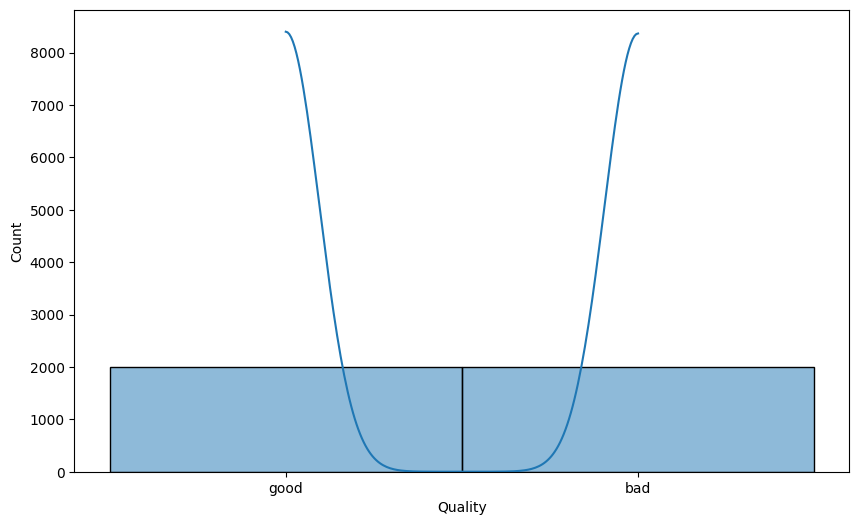

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True)

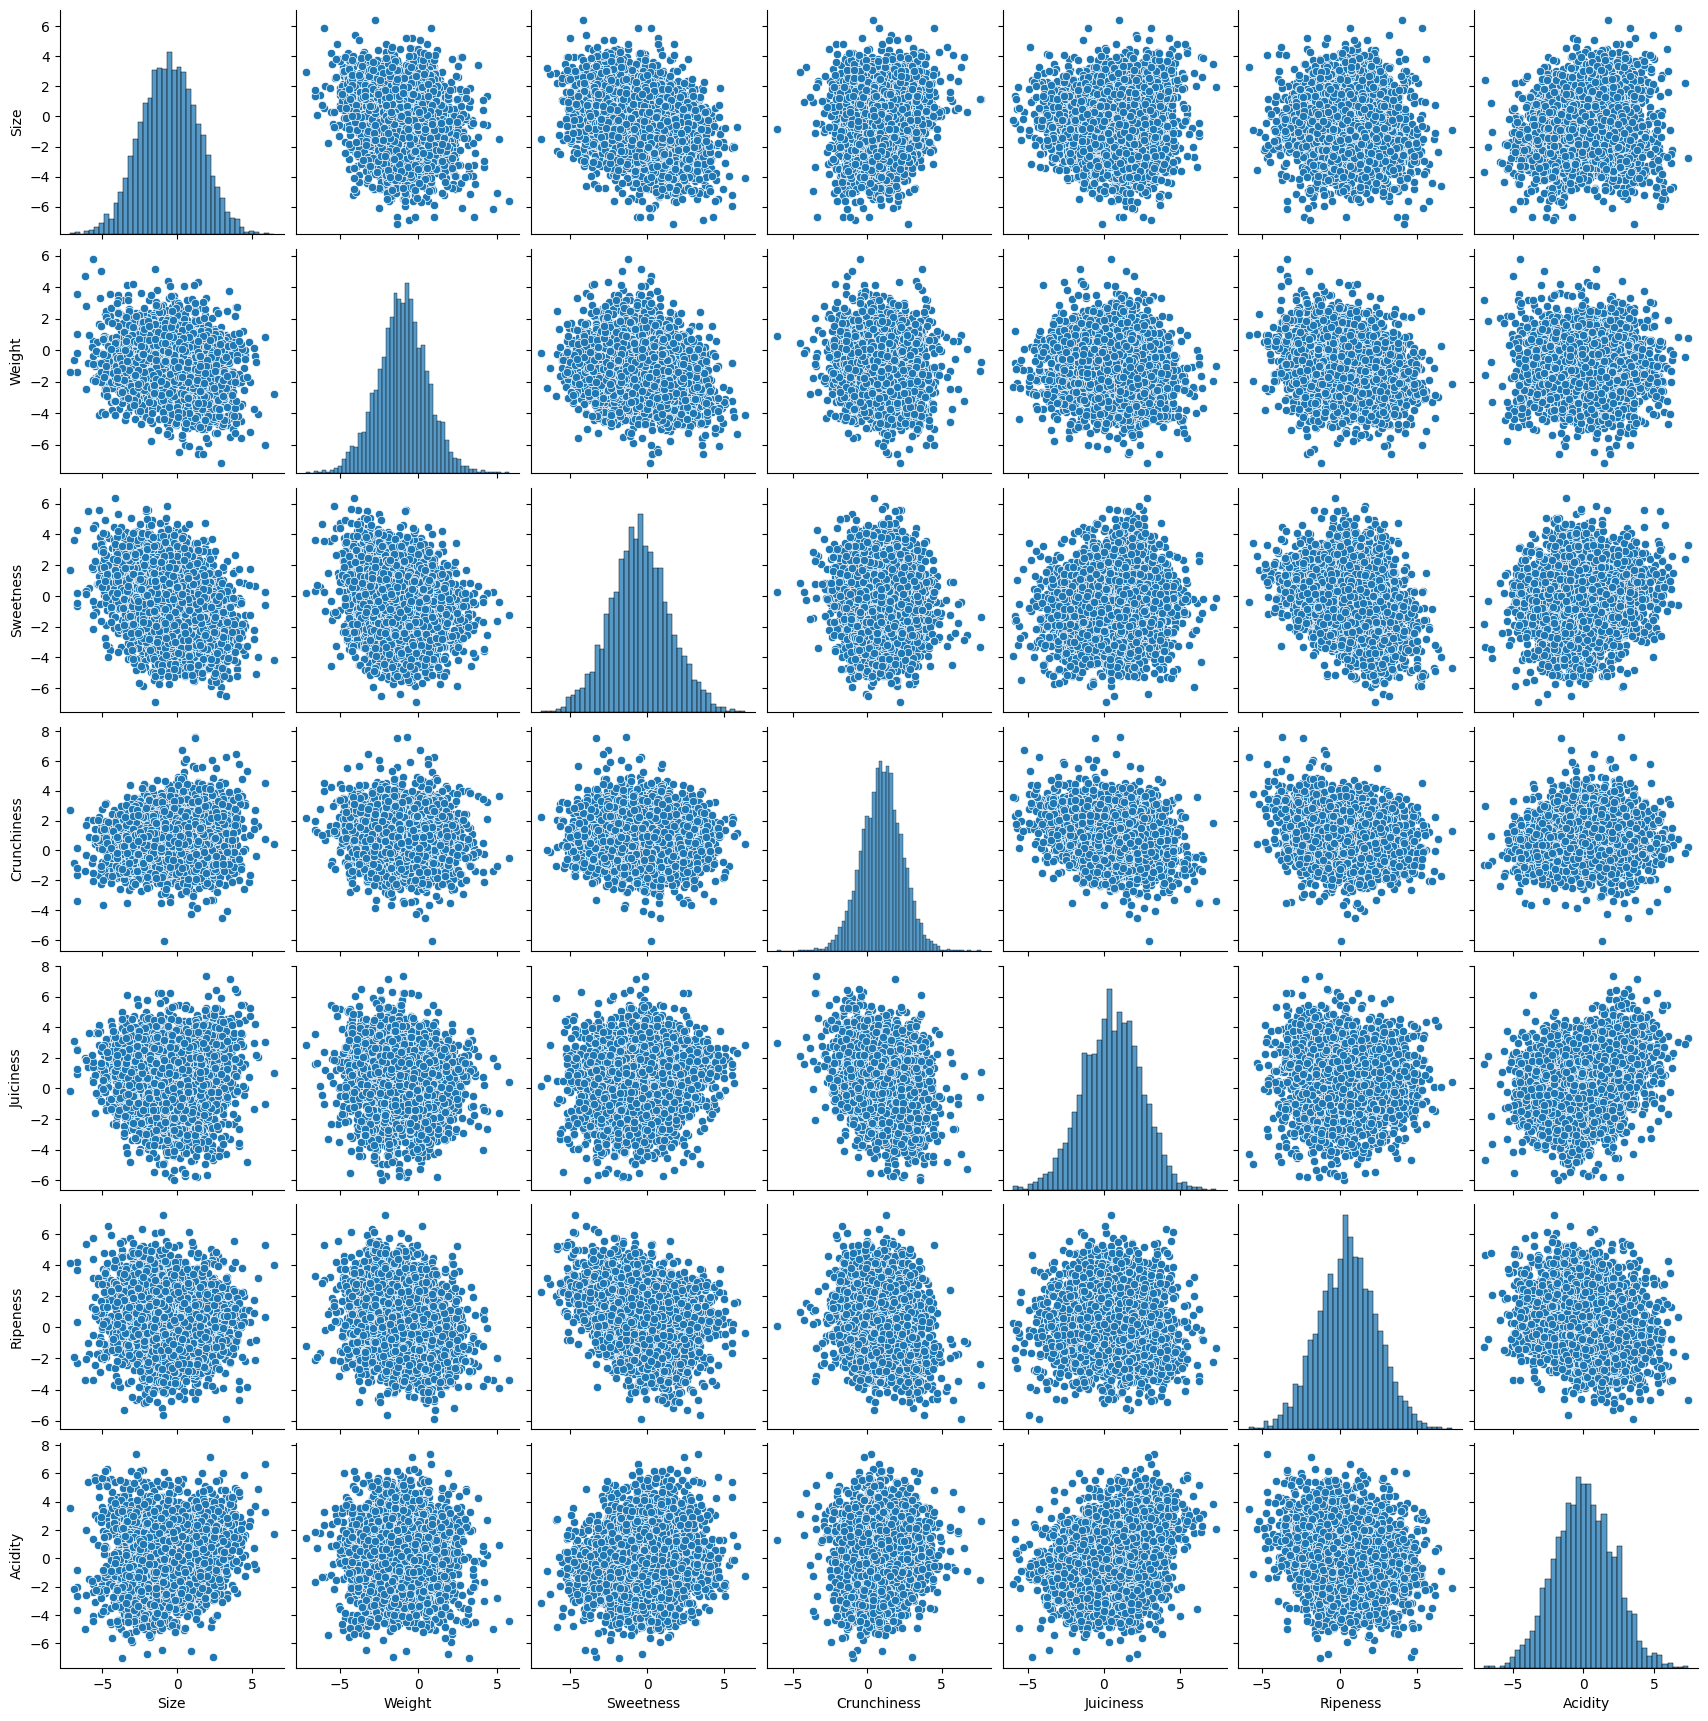

In [20]:
# There are no distinct trends in the data, mostly due to the already standardized data
sns.pairplot(df)

Each histogram for each individual feature is plotted to see the distribution of the data. We can see that the data is normally distributed for all of the features, so there is no need to normalize the data.

## 2.2 Plot Heatmap to check for correlation between features

<Axes: >

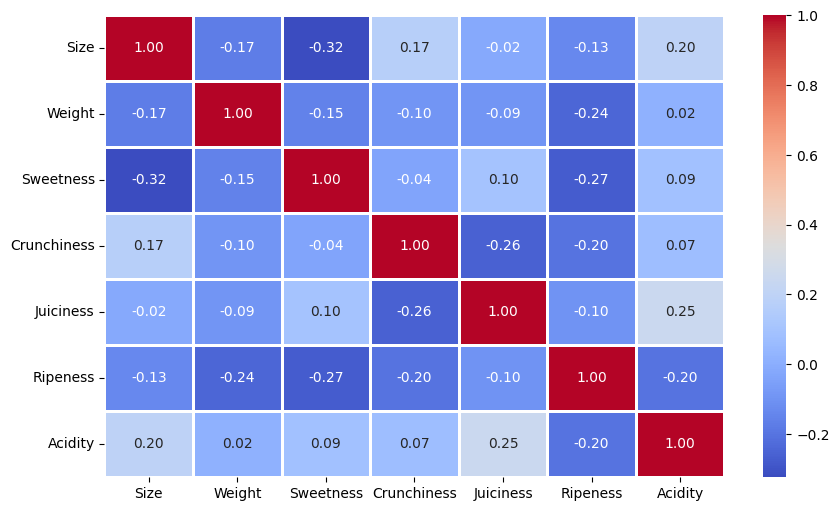

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=2)

There are no features that relatively stand out as highly correlated. We can see that the highest correlation is between the features "Sweetness" and "Size" with a correlation of -0.32. We'll use xgboost to check for feature importance.

# 3. Pipeline and Model Building
<b> Models within used:</b>
1. XGBoost Classifier
2. Catboost Classifier
3. Voting Classifier
    a. Linear Regression
    b. Decision Tree
    c. SVC
    d. Random Forest Classifier
    e. XGBoost
    f. Catboost
4. Deep Neural Network (Pytorch) - Custom Classes

All models were tested using Cross Validation with Stratified K Folds set to 5. Seed used: 42.

## 3.1 Base Model: XGBoost (non-tuned)

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [23]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Create an instance of StratifiedKFold for categorical target variable
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

# Train the model
scores = cross_val_score(xgb_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)

print(f'Cross Validation Scores: {scores}')
print(f'Mean Cross Validation Score: {scores.mean()}')

Cross Validation Scores: [0.95664997 0.94765574 0.95953085 0.96137658 0.94103458]
Mean Cross Validation Score: 0.9532495434525726


Accuracy: 0.90625
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       401
           1       0.91      0.91      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9062525390783692


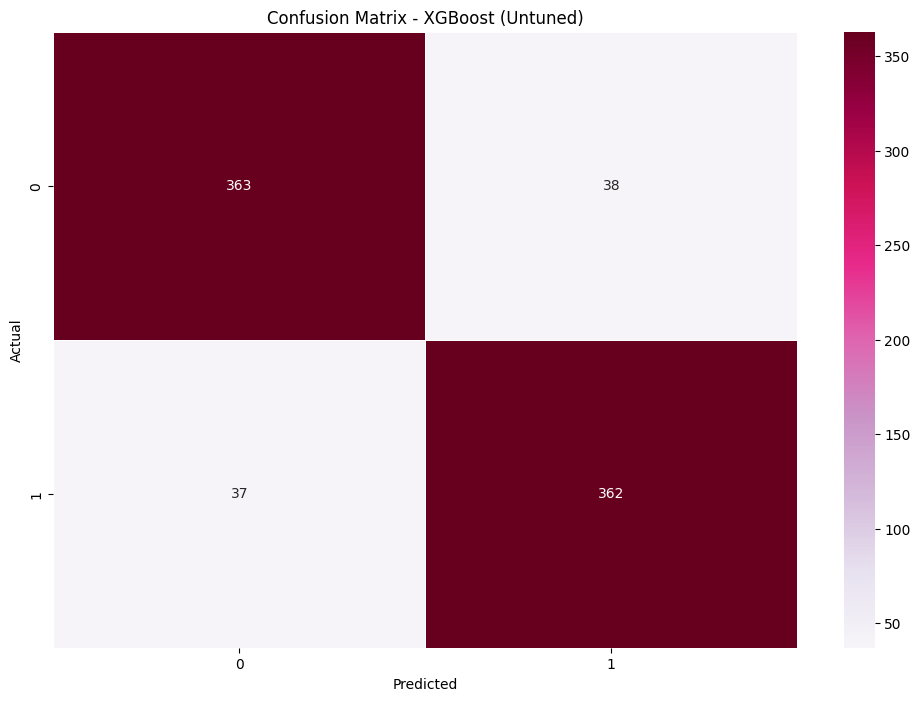

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

xgb_clf.fit(X_train, y_train_encoded)

y_pred = xgb_clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

# Create heatmap for Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d',linewidths=0.5, cmap='PuRd', )    
plt.title(f"Confusion Matrix - XGBoost (Untuned)"),
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 3.1.1 Tuning the XGBoost model using Optuna

In [25]:
import optuna

In [26]:
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **xgb_params)
    
    scores = cross_val_score(xgb_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

In [27]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

[I 2024-04-07 03:00:47,651] A new study created in memory with name: no-name-c3d46dc9-c9f2-4624-a5a5-9bae2b91e9b1


In [28]:
study.optimize(objective, n_trials=50)

[I 2024-04-07 03:00:48,875] Trial 0 finished with value: 0.9494565376615005 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.15599452033620265, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352, 'min_child_weight': 7}. Best is trial 0 with value: 0.9494565376615005.
[I 2024-04-07 03:00:49,755] Trial 1 finished with value: 0.9471889373919667 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.18182496720710062, 'reg_alpha': 1.8340450985343382, 'reg_lambda': 3.0424224295953772, 'min_child_weight': 6}. Best is trial 0 with value: 0.9494565376615005.
[I 2024-04-07 03:00:50,708] Trial 2 finished with value: 0.9443490659088468 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0

In [29]:
best_params = study.best_params

## 3.1.2 Tuned XGBoost model

Accuracy: 0.90625
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       401
           1       0.91      0.91      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9062525390783692


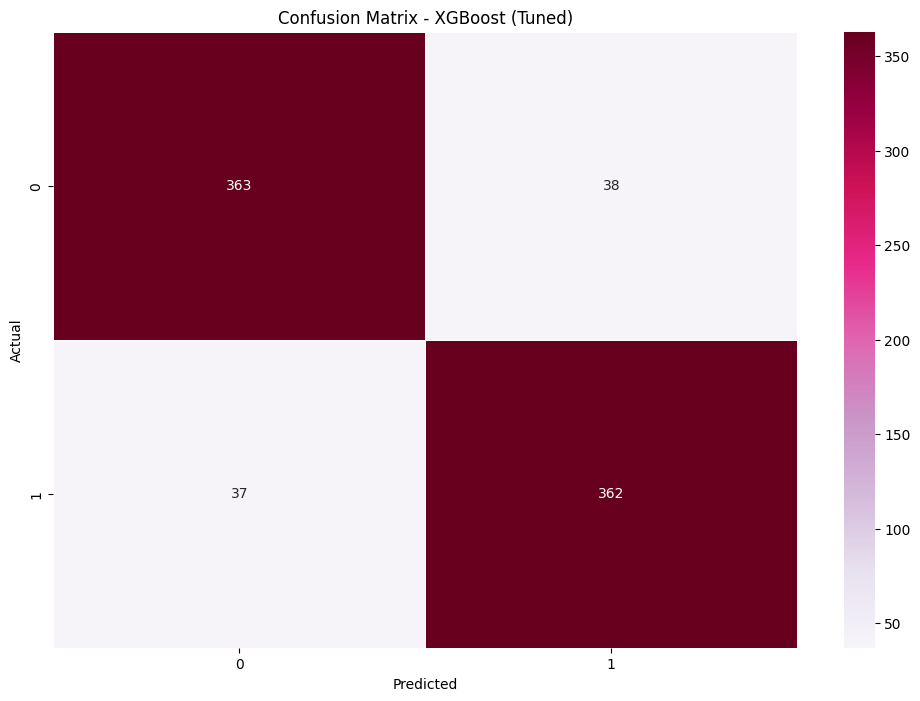

In [30]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **best_params)

xgb_clf.fit(X_train, y_train_encoded)

y_pred = xgb_clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

# Create heatmap for Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d',linewidths=0.5, cmap='PuRd', )    
plt.title(f"Confusion Matrix - XGBoost (Tuned)"),
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)

<Figure size 1000x600 with 0 Axes>

## 3.2 Catboost Base Model

In [32]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.3


In [33]:
# Create a CatBoostClassifier model
cat_clf = CatBoostClassifier(task_type='GPU', iterations=100, verbose=0)

scores = cross_val_score(cat_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc')

print(f'Cross Validation Scores: {scores}')

print(f'Mean Cross Validation Score: {scores.mean()}')

Cross Validation Scores: [0.95027295 0.94547798 0.9655563  0.96677702 0.94680612]
Mean Cross Validation Score: 0.9549780759577731


Accuracy: 0.9075
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       401
           1       0.90      0.92      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9075244220276378


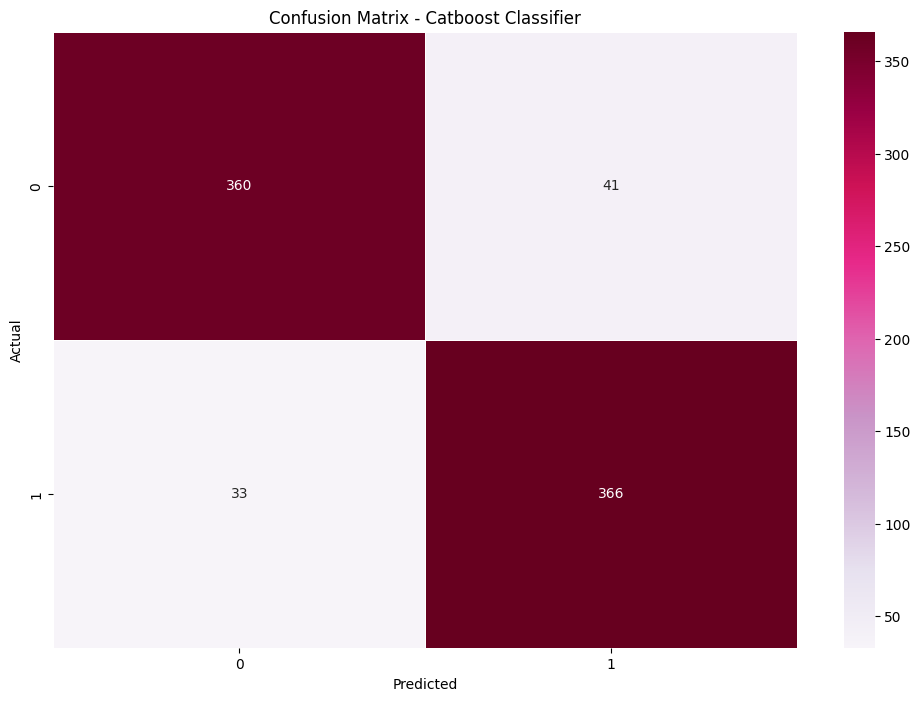

In [34]:
# Fit the model to the training data
cat_clf.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred = cat_clf.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

# Create heatmap for Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d',linewidths=0.5, cmap='PuRd', )    
plt.title(f"Confusion Matrix - Catboost Classifier"),
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 3.3 Voting Classifier (Base) w/ Cross Validation

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the individual classifiers
classifier1 = DecisionTreeClassifier(random_state=42)
classifier2 = LogisticRegression(random_state=42)
classifier3 = SVC(random_state=42, probability=True)
classifier4 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **best_params)
classifier5 = RandomForestClassifier(random_state=42)
classifier6 = CatBoostClassifier(task_type='GPU', iterations=100, verbose=0)

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('dt', classifier1), ('lr', classifier2), ('svc', classifier3), ('xgb', classifier4), ('cat', classifier5)],
    voting='soft'  # soft voting
)

scores = cross_val_score(voting_classifier, X_train, y_train_encoded, cv=stratified_kfold, n_jobs=-1)

print(f'Cross Validation Scores: {scores}')

print(f'Mean Cross Validation Score: {scores.mean()}')


Cross Validation Scores: [0.875     0.865625  0.884375  0.8765625 0.8625   ]
Mean Cross Validation Score: 0.8728125


## 3.3.1 Voting Classifier tuning with Optuna

In [36]:
# Create a new Objective function for Optuna for the Voting Classifier
def objective(trial):
    dt_params = {
        'criterion': trial.suggest_categorical('dt_criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('dt_max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('dt_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('dt_min_samples_leaf', 1, 10)
    }
    
    lr_params = {
        'C': trial.suggest_loguniform('lr_C', 0.1, 10.0),
        'max_iter': trial.suggest_int('lr_max_iter', 100, 1000),
        'l1_ratio': trial.suggest_float('lr_l1_ratio', 0, 1)
    }
    
    svc_params = {
        'C': trial.suggest_loguniform('svc_C', 0.1, 10.0),
        'gamma': trial.suggest_loguniform('svc_gamma', 0.01, 1.0),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10)
    }

    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 300),
        'learning_rate': trial.suggest_loguniform('cat_learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('cat_depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 0.0, 10.0)
    }
    
    # 1. Decision Tree
    dt_clf = DecisionTreeClassifier(max_depth=dt_params['max_depth'], min_samples_split=dt_params['min_samples_split'], 
                                    min_samples_leaf=dt_params['min_samples_leaf'], criterion=dt_params['criterion'],random_state=42)

    # 2. Logistic Regression
    lr_clf = LogisticRegression(max_iter=lr_params['max_iter'], C=lr_params['C'], solver='saga', 
                                penalty='elasticnet', l1_ratio=lr_params['l1_ratio'], random_state=42)

    # 3. Support Vector Classifier
    svc_clf = SVC(probability=True, C=svc_params['C'], gamma=svc_params['gamma'], kernel=svc_params['kernel'], random_state=42)

    # 4. XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=xgb_params['n_estimators'], 
                            max_depth=xgb_params['max_depth'], learning_rate=xgb_params['learning_rate'], subsample=xgb_params['subsample'], 
                            colsample_bytree=xgb_params['colsample_bytree'], reg_alpha=xgb_params['reg_alpha'], 
                            reg_lambda=xgb_params['reg_lambda'], min_child_weight=xgb_params['min_child_weight'], random_state=42)

    # 5. Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=rf_params['n_estimators'], max_depth=rf_params['max_depth'], 
                                    min_samples_split=rf_params['min_samples_split'], min_samples_leaf=rf_params['min_samples_leaf'], 
                                    random_state=42)
    # 6. CatBoost Classifier
    cat_clf = CatBoostClassifier(eval_metric='AUC', iterations=cat_params['iterations'], learning_rate=cat_params['learning_rate'],
                                depth=cat_params['depth'], l2_leaf_reg=cat_params['l2_leaf_reg'], verbose=False,random_state=42)

    # Suggest weights for each model
    models = [dt_clf, lr_clf, svc_clf, rf_clf, xgb_clf, cat_clf]

    weights = [trial.suggest_float(f'weight_{i}', 0, 1) for i in range(len(models))]
    
    # Ensure weights sum to 1 (optional)
    total = sum(weights)
    weights = [w / total for w in weights]
               
    voting_classifier = VotingClassifier(
        estimators=[('dt', dt_clf), ('lr', lr_clf), ('svc', svc_clf), ('rf', rf_clf), ('xgb', xgb_clf), ('cat', cat_clf)],
        voting='soft', # soft voting
        weights=weights
    )

    scores = cross_val_score(voting_classifier, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)

    return scores.mean()

In [37]:
study1 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

[I 2024-04-07 03:02:11,111] A new study created in memory with name: no-name-bd8532aa-3baf-4756-8bbf-52f28a2baf11


In [38]:
study1.optimize(objective, n_trials=50)

[I 2024-04-07 03:03:09,063] Trial 0 finished with value: 0.9556011289172746 and parameters: {'dt_criterion': 'entropy', 'dt_max_depth': 8, 'dt_min_samples_split': 7, 'dt_min_samples_leaf': 2, 'lr_C': 0.2051110418843398, 'lr_max_iter': 152, 'lr_l1_ratio': 0.8661761457749352, 'svc_C': 1.5930522616241019, 'svc_gamma': 0.2607024758370766, 'svc_kernel': 'poly', 'rf_n_estimators': 263, 'rf_max_depth': 4, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 6, 'xgb_n_estimators': 489, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.08012737503998542, 'xgb_subsample': 0.569746930326021, 'xgb_gamma': 0.29214464853521815, 'xgb_colsample_bytree': 0.6831809216468459, 'xgb_reg_alpha': 4.56069984217036, 'xgb_reg_lambda': 7.851759613930136, 'xgb_min_child_weight': 2, 'cat_iterations': 203, 'cat_learning_rate': 0.10150667045928574, 'cat_depth': 3, 'cat_l2_leaf_reg': 6.075448519014383, 'weight_0': 0.17052412368729153, 'weight_1': 0.06505159298527952, 'weight_2': 0.9488855372533332, 'weight_3': 0.96563203307455

In [39]:
study1.best_params
# {'dt_criterion': 'entropy',
#  'dt_max_depth': 4,
#  'dt_min_samples_split': 8,
#  'dt_min_samples_leaf': 8,
#  'lr_C': 6.527549752972141,
#  'lr_max_iter': 969,
#  'lr_l1_ratio': 0.4337568671456013,
#  'svc_C': 1.5556857873966423,
#  'svc_gamma': 0.14681019428301498,
#  'svc_kernel': 'rbf',
#  'rf_n_estimators': 854,
#  'rf_max_depth': 6,
#  'rf_min_samples_split': 2,
#  'rf_min_samples_leaf': 9,
#  'xgb_n_estimators': 452,
#  'xgb_max_depth': 10,
#  'xgb_learning_rate': 0.013838262695355694,
#  'xgb_subsample': 0.9823543338269651,
#  'xgb_gamma': 0.4258753464801609,
#  'xgb_colsample_bytree': 0.9949459559325061,
#  'xgb_reg_alpha': 2.996709566294335,
#  'xgb_reg_lambda': 6.103699549880966,
#  'xgb_min_child_weight': 1,
#  'cat_iterations': 290,
#  'cat_learning_rate': 0.026194095599180893,
#  'cat_depth': 7,
#  'cat_l2_leaf_reg': 1.8230381229344372,
#  'weight_0': 0.17038800826859224,
#  'weight_1': 0.002015723587246221,
#  'weight_2': 0.7966047820136877,
#  'weight_3': 0.27321856019502155,
#  'weight_4': 0.2480176764173019,
#  'weight_5': 0.7660175887545655}

{'dt_criterion': 'entropy',
 'dt_max_depth': 4,
 'dt_min_samples_split': 8,
 'dt_min_samples_leaf': 8,
 'lr_C': 6.527549752972141,
 'lr_max_iter': 969,
 'lr_l1_ratio': 0.4337568671456013,
 'svc_C': 1.5556857873966423,
 'svc_gamma': 0.14681019428301498,
 'svc_kernel': 'rbf',
 'rf_n_estimators': 854,
 'rf_max_depth': 6,
 'rf_min_samples_split': 2,
 'rf_min_samples_leaf': 9,
 'xgb_n_estimators': 452,
 'xgb_max_depth': 10,
 'xgb_learning_rate': 0.013838262695355694,
 'xgb_subsample': 0.9823543338269651,
 'xgb_gamma': 0.4258753464801609,
 'xgb_colsample_bytree': 0.9949459559325061,
 'xgb_reg_alpha': 2.996709566294335,
 'xgb_reg_lambda': 6.103699549880966,
 'xgb_min_child_weight': 1,
 'cat_iterations': 290,
 'cat_learning_rate': 0.026194095599180893,
 'cat_depth': 7,
 'cat_l2_leaf_reg': 1.8230381229344372,
 'weight_0': 0.17038800826859224,
 'weight_1': 0.002015723587246221,
 'weight_2': 0.7966047820136877,
 'weight_3': 0.27321856019502155,
 'weight_4': 0.2480176764173019,
 'weight_5': 0.7660

In [40]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study1)

<Figure size 1000x600 with 0 Axes>

### 3.5 Voting Classifier Model Evaluation

Accuracy: 0.92125
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       401
           1       0.91      0.93      0.92       399

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800

AUC Score: 0.9719185744910905


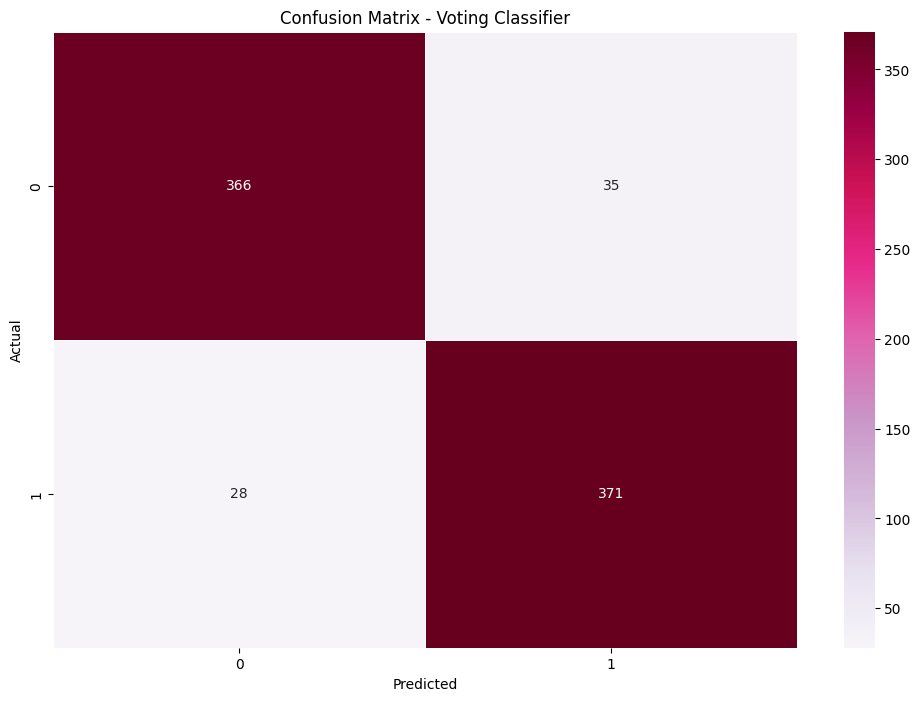

In [41]:
# Best parameters for voting classifier
best_params = study1.best_params

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('dt', DecisionTreeClassifier(criterion=best_params['dt_criterion'], max_depth=best_params['dt_max_depth'],
                                              min_samples_split=best_params['dt_min_samples_split'],
                                              min_samples_leaf=best_params['dt_min_samples_leaf'], random_state=42)),
                ('lr', LogisticRegression(C=best_params['lr_C'], max_iter=best_params['lr_max_iter'],
                                        l1_ratio=best_params['lr_l1_ratio'], solver='saga', 
                                        penalty='elasticnet', random_state=42)),
                ('svc', SVC(C=best_params['svc_C'], gamma=best_params['svc_gamma'],
                            kernel=best_params['svc_kernel'], probability=True, random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'],
                                            max_depth=best_params['rf_max_depth'],
                                            min_samples_split=best_params['rf_min_samples_split'],
                                            min_samples_leaf=best_params['rf_min_samples_leaf'],
                                            random_state=42)),
                ('xgb', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                        n_estimators=best_params['xgb_n_estimators'],
                                        max_depth=best_params['xgb_max_depth'],
                                        learning_rate=best_params['xgb_learning_rate'],
                                        subsample=best_params['xgb_subsample'],
                                        colsample_bytree=best_params['xgb_colsample_bytree'],
                                        reg_alpha=best_params['xgb_reg_alpha'],
                                        reg_lambda=best_params['xgb_reg_lambda'],
                                        min_child_weight=best_params['xgb_min_child_weight'],
                                        random_state=42)),
                ('cat', CatBoostClassifier(eval_metric='AUC', iterations=best_params['cat_iterations'],
                                        learning_rate=best_params['cat_learning_rate'],
                                        depth=best_params['cat_depth'],
                                        l2_leaf_reg=best_params['cat_l2_leaf_reg'],
                                        verbose=False, random_state=42))],
    voting='soft', # soft voting
    weights=[best_params[f'weight_{i}'] for i in range(6)]
    )

# Fit the Voting Classifier on the training data
voting_classifier.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred_proba = voting_classifier.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred_proba)}')

# Create heatmap for Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d',linewidths=0.5, cmap='PuRd', )    
plt.title(f"Confusion Matrix - Voting Classifier"),
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

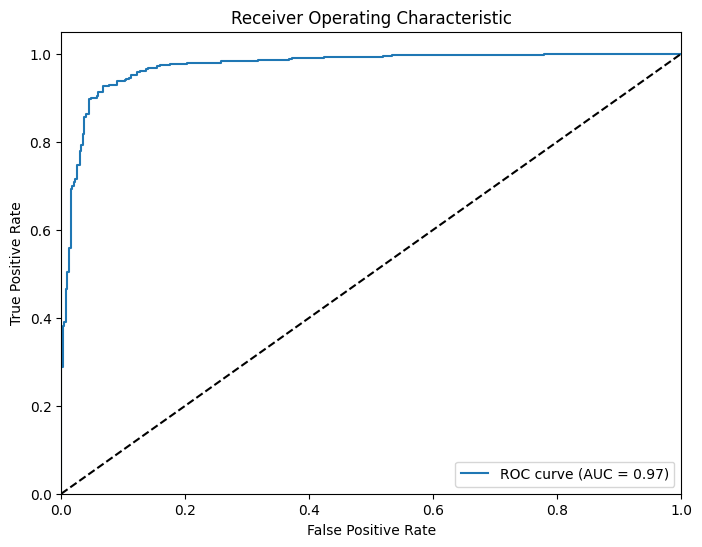

In [42]:
from sklearn.metrics import roc_curve, auc

# Assuming you have the predicted probabilities and true labels
y_pred_proba = voting_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 3.6 Deep Learning Network (Pytorch)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random

SEED = 42

# Set seeds
def set_seeds(seed):
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seeds(SEED)

# Only use deterministic algorithms - Will raise error if not
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

In [44]:
df = pd.read_csv(csv_path)

In [45]:
df['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

In [46]:
def preprocessing(csv_path):
    features = pd.read_csv(csv_path)
    features.drop(features.tail(1).index,inplace=True)
    features.drop(columns=['A_id'], inplace=True)
    labels = features.iloc[:, -1]
    features.drop('Quality', axis=1, inplace=True)
    features['Acidity'] = features['Acidity'].astype(float)
    return features, labels

In [47]:
from sklearn.model_selection import train_test_split
features, labels = preprocessing('/kaggle/input/apple-quality/apple_quality.csv')

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(3200, 7) (400, 7) (3200,) (400,)
(400, 7) (400, 7) (400,) (400,)


## 3.6.1 Create Custom Tensor Dataset

In [48]:
# Create Custom Tensor Dataset
class AppleDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()

        # Encode the labels
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)

        # Convert the encoded labels to a tensor
        self.labels = torch.tensor(encoded_labels, requires_grad=True, dtype=torch.float32)
        
        self.features = torch.tensor(features.to_numpy(), requires_grad=True, dtype=torch.float32)
        
        self.classes_ = features.columns
        
    # The required methods for custom dataset class
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return features, label
    
apple_train = AppleDataset(X_train, y_train)
apple_val = AppleDataset(X_val, y_val)
apple_test = AppleDataset(X_test, y_test)

In [49]:
features, label = apple_train[0]
print(f'Features: {features}')
print(f'Labels: {label}')

Features: tensor([ 1.4825, -2.5812, -0.3069,  1.5279,  1.0564,  2.5608, -1.2293],
       grad_fn=<SelectBackward0>)
Labels: 1.0


## 3.6.2 DataLoader Train Data w/ Custom Seed Initializations for Reproducible Results

In [50]:
torch.initial_seed()

42

In [51]:
# 1. Checking for seed being used in Pytorch
torch.initial_seed()

# 2. Initialize torch generator and set manual seed
g = torch.Generator()
g.manual_seed(42)

# 3. Shuffle needs to be false (even for train data) to be deterministic 
# Batch is randomly chosen even with worker init function
apple_train_dataloader = DataLoader(
    apple_train,
    batch_size = 32,
    shuffle=False,    
    worker_init_fn=set_seeds,
    generator=g
)
apple_val_dataloader = DataLoader(
    apple_val,
    batch_size=32,
    shuffle=False,
    worker_init_fn=set_seeds,
    generator=g
)
apple_test_dataloader = DataLoader(
    apple_test,
    batch_size=32,
    shuffle=False,
    worker_init_fn=set_seeds,
    generator=g
)

In [52]:
features, labels = next(iter(apple_train_dataloader))
print(f'Features: {features}')
print(f'Labels: {label}')

Features: tensor([[ 1.4825, -2.5812, -0.3069,  1.5279,  1.0564,  2.5608, -1.2293],
        [-0.1661,  0.3856, -1.1029,  0.4738,  0.3255,  0.9832, -2.1719],
        [-2.5089, -2.8434, -0.8484, -0.4834, -0.0953,  5.1110, -1.8053],
        [-1.3805, -0.5214,  3.3357,  0.1440,  2.5138, -0.4667, -0.0305],
        [-2.0736, -1.2128, -0.8184,  3.8088,  1.0139,  0.7487,  0.0261],
        [-1.3741, -0.8000, -0.1954, -0.5217,  4.0766, -1.9733,  4.3481],
        [-1.2946,  2.8312, -2.7419,  0.9157,  0.8033,  0.0464, -4.4883],
        [-1.9753,  0.1489, -2.0653,  0.9718,  1.0100, -1.9965, -1.3108],
        [-1.7967,  0.3704, -1.0569,  1.8060,  2.4348, -0.3600, -2.9201],
        [ 1.6687,  2.7040,  0.3525,  0.1058,  2.0746, -1.6856,  3.5990],
        [ 2.7287, -2.7389, -4.5692,  3.4290,  2.3881,  0.5349,  0.4458],
        [-0.7827, -2.6366, -2.1953,  0.3983, -1.5029,  1.0904, -4.5755],
        [-1.4844, -1.1146, -4.6922, -1.3674,  0.1112,  6.0662, -1.9557],
        [-1.3768,  1.0880,  0.8262, -0.22

## 3.6.3 Building the Forward Pass Neural Network

In [53]:
class DeepNeuralNet(nn.Module):
    def __init__(self):
        super(DeepNeuralNet, self).__init__()
        # Defining the Layers
        self.fc1 = nn.Linear(7, 14)
        self.bn1 = nn.BatchNorm1d(14)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(14, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(7, 1)

        # Apply He initialization to create uniform weights for the model
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='sigmoid')

    def forward(self, x):
        x = nn.functional.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = nn.functional.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

## 3.6.4 Custom Early Stopping Function

In [54]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        # Initial val_loss
        if self.best_loss is None:
            self.best_loss = val_loss
            
        # Checking the state where best_loss - val_loss is greater than min_data
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            
        # Otherwise iterate counter and check patience
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## 3.6.5 Training Loop w/ loss function and optimizer

In [55]:
# Utilize GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [56]:
from tqdm import tqdm

# Define the model
net = DeepNeuralNet()
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Define Number of Epochs
num_epochs = 150

# Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Array to hold average losses per epoch
train_losses, val_losses = [], []

def create_model(model, train, val, loss, optimizer, num_epochs, early_stop=False, verbose=False):
    model = model.to(device)
    criterion = loss
    optimizer = optimizer
    
    # Reset Seeds for Training Loop
    set_seeds(seed=42)

    for epoch in tqdm(range(num_epochs)):
        train_running_loss = 0.0
        # Iterate over training batches
        for features, labels in train:
            features, labels = features.to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Sum of Loss
            train_running_loss += loss.item()
            
        # Calculate the average loss for the epoch
        train_loss = train_running_loss / len(train)
        
        # Create Evaluation Loop
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for features, labels in val:
                features, labels = features.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                # Sum of Loss
                val_running_loss += loss.item()

        # Calculate the average loss for the epoch
        val_loss = val_running_loss / len(val)
        
        # Check val_loss for early stopping
        if early_stop:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print('Early Stopping')
                break
        
        # Append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        
        if verbose:
            print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Best Train Loss: {min(train_losses)}, Best Validation Loss: {min(val_losses)}')
        
        
create_model(net, apple_train_dataloader, apple_val_dataloader, \
             criterion, optimizer, num_epochs, early_stop=True, verbose=False)

 91%|█████████ | 136/150 [01:15<00:07,  1.81it/s]

Early Stopping
Best Train Loss: 0.1867436031997204, Best Validation Loss: 0.23241990288862815


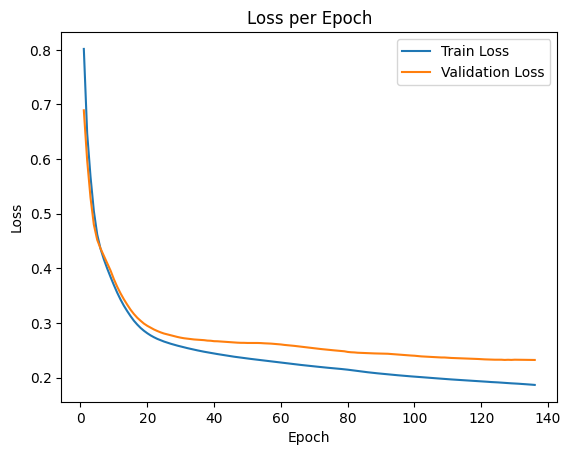

In [57]:
epoch_numbers = range(1, len(train_losses) + 1)

plt.plot(epoch_numbers, train_losses)
plt.plot(epoch_numbers, val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()


## 3.6.6 Deep Neural Network Prediction and Metrics

In [58]:
from torchmetrics import Accuracy

acc = Accuracy(task='binary').to(device)

net.eval()
with torch.no_grad():
    for features, labels in apple_test_dataloader:
        features, labels = features.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels)
        
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9125000238418579


## 3.6.7 DNN Hyperparameter Tuning using Optuna

In [59]:
import optuna
from optuna.trial import TrialState
import torch.nn as nn

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []

    # Static In-Feature
    in_features = len(apple_train.classes_)
    for i in range(n_layers):
        # Choosing number of Out-Features (Integer)
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)

        # Define and initialize linear layer
        linear = nn.Linear(in_features, out_features)
        
        # Initialization has to be executed right after the instantiation of the linear layer
        # Otherwise the results are not the same
        nn.init.kaiming_normal_(linear.weight, nonlinearity='leaky_relu')
        layers.append(linear)
        
        # Add Batch Normalization
        layers.append(nn.BatchNorm1d(out_features))  # Use out_features for batch normalization
        
        # Use LeakyReLU for activation to inhibit dead neurons and optimize slope for leaky relu
        negative_slope = trial.suggest_float("leaky_relu_slope_l{}".format(i), 1e-2, 0.3) 
        layers.append(nn.LeakyReLU(negative_slope))
        
        # Use dropout to withstand overfitting
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
        layers.append(nn.Dropout(p))

        in_features = out_features

    # Output layer
    layers.append(nn.Linear(in_features, 1))
    # Initialize the final layer
#     nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='linear')

    return nn.Sequential(*layers)

In [60]:
from torchmetrics import AUROC

def objective(trial):
    set_seeds(SEED)
    model = define_model(trial).to(device)
    # Create an AUROC metric instance
    auroc_metric = AUROC(task='binary').to(device)
    criterion = nn.BCEWithLogitsLoss()

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(10):  # Using 10 for simplicity
        model.train()
        for features, labels in apple_train_dataloader:
            features, labels = features.to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Create Evaluation Loop for AUROC
        model.eval()
        auroc_metric.reset()  # Resetting the metric is needed for each epoch
        with torch.no_grad():
            for features, labels in apple_val_dataloader:
                features, labels = features.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(features)
                # Assuming your model outputs logits, apply sigmoid to convert to probabilities
                probs = torch.sigmoid(outputs)
                auroc_metric.update(probs, labels.int())

        # Compute the AUROC score
        auroc_score = auroc_metric.compute()

        trial.report(auroc_score.item(), epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return auroc_score.item()  # Return the final AUROC score as a float


## 3.6.8 Running Optuna Study

In [61]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-07 03:23:16,994] A new study created in memory with name: no-name-1a41fee0-59c8-4596-be0d-6a5244b2e665
[I 2024-04-07 03:23:22,510] Trial 0 finished with value: 0.7072079181671143 and parameters: {'n_layers': 2, 'n_units_l0': 122, 'leaky_relu_slope_l0': 0.22227824312530747, 'dropout_l0': 0.4394633936788146, 'n_units_l1': 23, 'leaky_relu_slope_l1': 0.055238410897498764, 'dropout_l1': 0.2232334448672798, 'optimizer': 'Adam', 'lr': 1.2087541473056957e-05}. Best is trial 0 with value: 0.7072079181671143.
[I 2024-04-07 03:23:30,289] Trial 1 finished with value: 0.9559323787689209 and parameters: {'n_layers': 5, 'n_units_l0': 108, 'leaky_relu_slope_l0': 0.07157834209670008, 'dropout_l0': 0.2727299868828402, 'n_units_l1': 26, 'leaky_relu_slope_l1': 0.09823025045826593, 'dropout_l1': 0.4099025726528951, 'n_units_l2': 57, 'leaky_relu_slope_l2': 0.09445645065743215, 'dropout_l2': 0.44474115788895174, 'n_units_l3': 21, 'leaky_relu_slope_l3': 0.09472194807521325, 'dropout_l3': 0.34654473

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  50
  Number of complete trials:  50
Best trial:
  Value:  0.9664115905761719
  Params: 
    n_layers: 2
    n_units_l0: 66
    leaky_relu_slope_l0: 0.2167936109149597
    dropout_l0: 0.20980388226186727
    n_units_l1: 108
    leaky_relu_slope_l1: 0.03990551693865465
    dropout_l1: 0.21373808777059305
    optimizer: Adam
    lr: 0.006191330975127627


In [62]:
## Trial Selector
# trial_number = 0  # Example trial number
# selected_trial = [trial for trial in study.trials if trial.number == trial_number][0]
# selected_trial.params

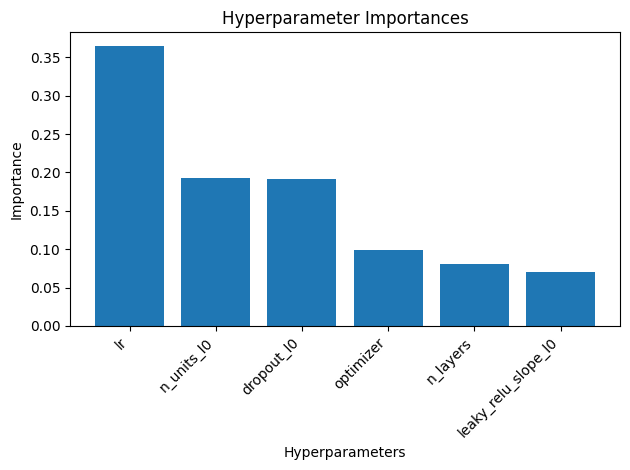

In [63]:
import matplotlib.pyplot as plt
importance_dict = optuna.importance.get_param_importances(study)
# Sorting the dictionary for better visualization
importance_dict_sorted = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

# Creating the plot
fig, ax = plt.subplots()
ax.bar(importance_dict_sorted.keys(), importance_dict_sorted.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Hyperparameters')
plt.ylabel('Importance')
plt.title('Hyperparameter Importances')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

## 3.6.9 Visual Accuracy - Optuna

In [64]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)

<Figure size 1000x600 with 0 Axes>

In [65]:
params = study.best_params

In [66]:
params

{'n_layers': 2,
 'n_units_l0': 66,
 'leaky_relu_slope_l0': 0.2167936109149597,
 'dropout_l0': 0.20980388226186727,
 'n_units_l1': 108,
 'leaky_relu_slope_l1': 0.03990551693865465,
 'dropout_l1': 0.21373808777059305,
 'optimizer': 'Adam',
 'lr': 0.006191330975127627}

## 3.6.10 Using best params from Optuna to tune DNN

In [67]:
# # Sequential Method

# def net(params):
#     # Define the sequential model
#     in_features = len(apple_train.classes_)  # Placeholder for actual number of input features

#     layer0 = nn.Linear(in_features, params['n_units_l0'])
#     nn.init.kaiming_normal_(layer0.weight, nonlinearity='leaky_relu')
#     layer1 = nn.Linear(params['n_units_l0'], params['n_units_l1'])
#     nn.init.kaiming_normal_(layer1.weight, nonlinearity='leaky_relu')
    
#     model = nn.Sequential(
#         layer0,
#         nn.BatchNorm1d(params['n_units_l0']),
#         nn.LeakyReLU(negative_slope=params['leaky_relu_slope_l0']),
#         nn.Dropout(p=params['dropout_l0']),

#         layer1,
#         nn.BatchNorm1d(params['n_units_l1']),
#         nn.LeakyReLU(negative_slope=params['leaky_relu_slope_l1']),
#         nn.Dropout(p=params['dropout_l1']),

#         nn.Linear(params['n_units_l1'], 1)
#     )

#     return model


In [68]:
import torch.nn.functional as F

class DeepNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input features
        in_features = len(apple_train.classes_)  
        
        # Define the Layers (Order is Very Important - Even Initialization of Weights)
        self.layer0 = nn.Linear(in_features, params['n_units_l0'])
        nn.init.kaiming_normal_(self.layer0.weight, nonlinearity='leaky_relu')
        self.bn0 = nn.BatchNorm1d(params['n_units_l0'])
        self.drop0 = nn.Dropout(p=params['dropout_l0'])
        
        self.layer1 = nn.Linear(params['n_units_l0'], params['n_units_l1'])
        nn.init.kaiming_normal_(self.layer1.weight, nonlinearity='leaky_relu')
        self.bn1 = nn.BatchNorm1d(params['n_units_l1'])
        self.drop1 = nn.Dropout(p=params['dropout_l1'])
        
        #Output layer
        self.last_layer = nn.Linear(params['n_units_l1'], 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn0(self.layer0(x)), negative_slope=params['leaky_relu_slope_l0'])
        x = self.drop0(x)
        
        x = F.leaky_relu(self.bn1(self.layer1(x)), negative_slope=params['leaky_relu_slope_l1'])
        x = self.drop1(x)
        
        x = self.last_layer(x)
        return x


In [69]:
from tqdm import tqdm

# Reset Seeds for Training Loop
set_seeds(seed=42)

# Define the model
net = DeepNeuralNet()
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'])

# Define Number of Epochs
num_epochs = 10
# Training of the model
model = net.to(device)

training_losses, validation_losses = [], []

def random_func():
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_running_loss = 0.0
        for features, labels in apple_train_dataloader:
            features, labels = features.to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Sum of Loss
            train_running_loss += loss.item()
            
        # Calculate the average loss for the epoch
        train_loss = train_running_loss / len(apple_train_dataloader)

        # Create Evaluation Loop
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for features, labels in apple_val_dataloader:
                features, labels = features.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, labels)

                # Sum of Loss
                val_running_loss += loss.item()

        # Calculate the average loss for the epoch
        val_loss = val_running_loss / len(apple_val_dataloader)
        
        # Append losses
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        

random_func()


 10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch: 1/10, Training Loss: 0.44570366278290746, Validation Loss: 0.30986660375044894


 20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Epoch: 2/10, Training Loss: 0.37015494495630263, Validation Loss: 0.29203419158091914


 30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch: 3/10, Training Loss: 0.3535331888496876, Validation Loss: 0.284882046855413


 40%|████      | 4/10 [00:02<00:03,  1.82it/s]

Epoch: 4/10, Training Loss: 0.3523936384916306, Validation Loss: 0.2712413490964816


 50%|█████     | 5/10 [00:02<00:02,  1.83it/s]

Epoch: 5/10, Training Loss: 0.3366544598340988, Validation Loss: 0.2624361010698172


 60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch: 6/10, Training Loss: 0.3363498210906982, Validation Loss: 0.25650051408089125


 70%|███████   | 7/10 [00:03<00:01,  1.78it/s]

Epoch: 7/10, Training Loss: 0.32821893215179443, Validation Loss: 0.26463552850943345


 80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

Epoch: 8/10, Training Loss: 0.30818632662296297, Validation Loss: 0.25006960790890914


 90%|█████████ | 9/10 [00:04<00:00,  1.79it/s]

Epoch: 9/10, Training Loss: 0.3027767810225487, Validation Loss: 0.2457965463399887


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Epoch: 10/10, Training Loss: 0.314738642424345, Validation Loss: 0.242294219823984


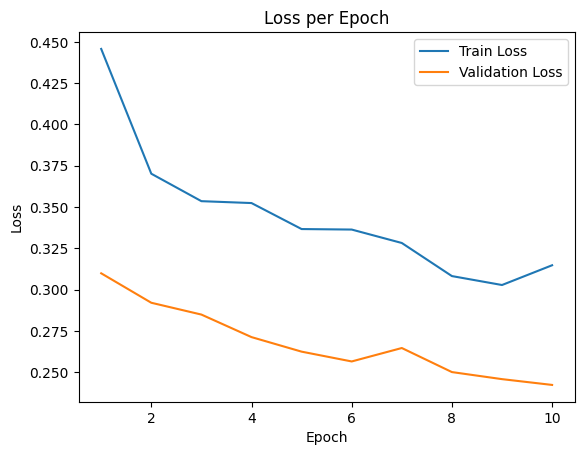

In [70]:
epoch_numbers = range(1, len(training_losses) + 1)
plt.plot(epoch_numbers, training_losses)
plt.plot(epoch_numbers, validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()


## 3.6.11 Evaluating the tuned DNN

In [71]:
from torchmetrics import Accuracy, AUROC
import torch

# Ensure that the metrics are being ran on the GPU
acc = Accuracy(task='binary').to(device)
auroc = AUROC(task='binary').to(device)

# Set to model evaluation
model.eval()
# Reset metrics at the start
acc.reset()  
auroc.reset()

# Do not update the gradients for evaluation
with torch.no_grad():
    for features, labels in apple_test_dataloader:
        features, labels = features.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        outputs = model(features)  # Assuming 'model' is your trained model
        
        # For Accuracy, use binary predictions
        preds = torch.sigmoid(outputs) >= 0.5  # Convert logits to probabilities then to binary predictions
        acc(preds.int(), labels.int())
        
        # For AUROC, use raw probabilities
        probabilities = torch.sigmoid(outputs)
        auroc(probabilities, labels.int())
        
test_accuracy = acc.compute()
test_auroc = auroc.compute()
print(f"Test accuracy: {test_accuracy}")
print(f"Test AUROC: {test_auroc}")


Test accuracy: 0.8924999833106995
Test AUROC: 0.961591362953186


# 4. Using joblib to dump classifiers

In [72]:
# from joblib import dump, load

In [73]:
# dump(voting_classifier, 'apple_quality_xgb.joblib')

# 5. Summary

In this notebook, we have utilized various tabular predictive models for our Binary Classification Dataset. Models like XGBoost, Catboost, Voting Classifier with an ensemble of various linear and non-linear model's ensembled together. Then we implemented our deep neural network with Pytorch, learning to create our own custom classes for the model, dataset, training, and validation loops. From there we further optimized our models, based on the hyperparameter tuning library - Optuna, with the goal of reaching a high AUROC score for our binary classification dataset. Our end results were averaging an Accuracy of 91% for our voting classifier and our pytorch (DNN) was averaging an accuracy of 89% although 96% AUC.

All in all, we learned that the appropriate models needed for binary classification datasets, require understanding the underlying features of our data, given that tabular data is somewhat much harder for a DNN to predict, more refined predictive models are well-designed for such tasks.